In [3]:
import os
import torch
from retrievers.xknow import RetXKnow
from retrievers.colbert import ColBERTConfig
from transformers import AutoConfig

xknow_ckpt = "ckpts/xknow/vid2r/base/xknow_pretrained.pth"

dir_name = os.path.dirname(xknow_ckpt)
model_cfg = AutoConfig.from_pretrained(dir_name)
colbert_cfg = ColBERTConfig.load_from_checkpoint(dir_name)

model = RetXKnow(model_cfg, colbert_cfg)
model.load_state_dict(torch.load(xknow_ckpt)["model"])
model.eval()

/opt/conda/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


RetXKnow(
  (model): HF_ColBERT(
    (linear): Linear(in_features=768, out_features=128, bias=False)
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (de

In [4]:
from retrievers.colbert import QueryTokenizer
query_tokenizer = QueryTokenizer(colbert_cfg)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from dataset.base import ImageDataset
from transformers import CLIPImageProcessor
from torch.utils.data import DataLoader

data_dir = "data/cat_dog"
img_list = os.listdir(data_dir)
img_processor = CLIPImageProcessor.from_pretrained(model_cfg.vision_model_name)
img_dataset = ImageDataset(img_list, data_dir, img_processor=img_processor)
img_dataloader = DataLoader(img_dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=False)
len(img_dataset)

The number of removed data: 0
The number of existing data: 224


224

In [6]:
device = torch.device("cuda:0")
model = model.to(device)

In [7]:
from tqdm import tqdm

question = "What is the dog or puppy's species?"
input_ids = query_tokenizer.tok(['. ' + question], return_tensors="pt").input_ids
input_ids[:, 1] = query_tokenizer.Q_marker_token_id
input_ids[input_ids == query_tokenizer.pad_token_id] = query_tokenizer.mask_token_id
mask = torch.ones((input_ids.size(0), input_ids.size(1)))

input_ids = input_ids.expand(4, -1)

Qs = []
with torch.no_grad():
    for batch in tqdm(img_dataloader):
        images, paths = batch
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        images = images.to(device)
        # query
        Q_t, Q_i = model.embed_VL(input_ids, mask, images)
        Q = model.query(Q_t, Q_i, mask)
        Qs.append(Q.detach().cpu())
        
dog_feats = []
for q in Qs:
    dog_feats.append(q[:,16:20,:].mean(dim=1).detach())
dog_feats = torch.cat(dog_feats, dim=0)

100%|██████████| 56/56 [00:10<00:00,  5.27it/s]


In [8]:
from tqdm import tqdm

question = "Where is the place in the image?"
input_ids = query_tokenizer.tok(['. ' + question], return_tensors="pt").input_ids
input_ids[:, 1] = query_tokenizer.Q_marker_token_id
input_ids[input_ids == query_tokenizer.pad_token_id] = query_tokenizer.mask_token_id
mask = torch.ones((input_ids.size(0), input_ids.size(1)))

input_ids = input_ids.expand(4, -1)

Qs = []
with torch.no_grad():
    for batch in tqdm(img_dataloader):
        images, paths = batch
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        images = images.to(device)
        # query
        Q_t, Q_i = model.embed_VL(input_ids, mask, images)
        Q = model.query(Q_t, Q_i, mask)
        Qs.append(Q.detach().cpu())
        
place_feats = []
for q in Qs:
    place_feats.append(q[:,16:20,:].mean(dim=1).detach())
place_feats = torch.cat(place_feats, dim=0)

100%|██████████| 56/56 [00:09<00:00,  6.04it/s]


In [9]:
from tqdm import tqdm

question = "What is the cat or kitty's species?"
input_ids = query_tokenizer.tok(['. ' + question], return_tensors="pt").input_ids
input_ids[:, 1] = query_tokenizer.Q_marker_token_id
input_ids[input_ids == query_tokenizer.pad_token_id] = query_tokenizer.mask_token_id
mask = torch.ones((input_ids.size(0), input_ids.size(1)))

input_ids = input_ids.expand(4, -1)

Qs = []
with torch.no_grad():
    for batch in tqdm(img_dataloader):
        images, paths = batch
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        images = images.to(device)
        # query
        Q_t, Q_i = model.embed_VL(input_ids, mask, images)
        Q = model.query(Q_t, Q_i, mask)
        Qs.append(Q.detach().cpu())
        
cat_feats = []
global_feats = []
for q in Qs:
    cat_feats.append(q[:,16:20,:].mean(dim=1).detach())
    global_feats.append(q[:,:16].mean(dim=1).detach())
cat_feats = torch.cat(cat_feats, dim=0)
global_feats = torch.cat(global_feats, dim=0)

100%|██████████| 56/56 [00:10<00:00,  5.23it/s]


In [10]:
dog_np = dog_feats.numpy()
cat_np = cat_feats.numpy()
global_np = global_feats.numpy()
place_np = place_feats.numpy()

In [12]:
import numpy as np
import umap
# Combine tensors into one dataset
data = np.vstack((dog_np, cat_np, place_np, global_np))
# Create labels for the classes
labels = np.array([0] * 224 + [1] * 224 + [2] * 224 + [3] * 224)
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.5, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(data)

/opt/conda/envs/llava/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


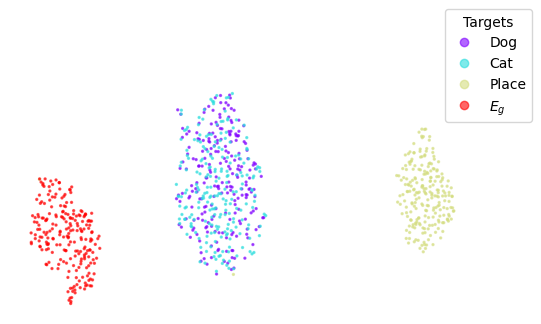

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the results
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)#, projection="3d")
# ax.view_init(elev=40., azim=120)
# Scatter plot, umap_result[:, 2]
scatter = ax.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='rainbow', s=2, alpha=0.6)
legend_labels = ["Dog", "Cat", "Place", r"$E_g$"]
handles, _ = scatter.legend_elements()
ax.axis(False)
# legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.legend(handles, legend_labels, title="Targets", fontsize=10, title_fontsize=10, bbox_to_anchor=(0.92, 0.8), loc='best')